In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools
import warnings

import pandas as pd
import statsmodels.api as sm 

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_error(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    output = list(result.params)
    output.extend(list(result.bse))
    return pd.Series(output, ["slope", "intercept", "slope_e", "intercept_e"])

sns.set(style="darkgrid", palette="Set2") 

# Importing multiple plates with different layouts

In [36]:
files = [
             #    # 200 µM paraquat
             # ["growth_data/cyrus_031524_paraquat_Mn.txt", 
             # {"A": "0 nM Mn", "B": "10^0 nM Mn", "C": "10^1 nM Mn", "D": "10^2 nM Mn", 
             #  "E": "10^3 nM Mn","F": "10^4 nM Mn", "G": "10^5 nM Mn", "H": "10^6 nM Mn"},
             # [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
             #  12],

             ["growth_data/gc0.txt", 
             {"A": "0 nM Mn", "B": "10^0 nM Mn", "C": "10^1 nM Mn", "D": "10^2 nM Mn", 
              "E": "10^3 nM Mn","F": "10^4 nM Mn", "G": "10^5 nM Mn", "H": "10^6 nM Mn"},
             [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             [["A", "B", "C", "D", "E", "F", "G", "H"]],
             {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
              12],
    
        ]


for i, file in enumerate(files):

    fname = file[0]
    additive = file[1]
    genotype_col = file[2]
    genotype_row = file[3]
    genotype_combinations = file[4]
    n_replicate = file[5]

    al = pl.DataFrame(additive).transpose(include_header=True)
    al = al.rename({"column": "Row", "column_0": "Additive"})
    al = al.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    gl = []
    
    for genotype, idx in genotype_combinations.items():
    
        gl.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

    gl = pl.DataFrame(gl).transpose()
    gl = gl.rename({"column_0": "Genotype", "column_1": "Well"})
    gl = gl.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    if i == 0:    
        df = pl.read_csv(fname, separator="\t") # growth_data/cyrus_mutant_013124.txt
        df = df.with_columns(Plate = pl.lit("Plate 1"))
        df = df.with_columns(N_replicate = n_replicate)
        df = df.drop('T600')

        gdf = gl
        adf = al

    else:
        df_add = pl.read_csv(fname, separator="\t")
        df_add = df_add.with_columns(Plate = pl.lit(f"Plate {i+1}"))
        df_add = df_add.with_columns(N_replicate = n_replicate)
        df_add = df_add.drop('T600')
        df = pl.concat([df, df_add])

        gdf = pl.concat([gdf, gl])
        adf = pl.concat([adf, al])

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# get minimum OD measured, used to be 1.5
init_df = df.filter(pl.col("Time") > 1.5).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD")
init_df = init_df.group_by(["Plate", "Well"]).min()

init_df_median = df.filter(pl.col("Time") < 5).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD_median")
init_df_median = init_df_median.group_by(["Plate", "Well"]).median()

init_df

# blank_df.head(3)
df.head(3)

Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,…,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,Plate,N_replicate
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32
0.071111,0.087,0.101,0.087,0.09,0.085,0.092,0.087,0.086,0.087,0.089,0.086,0.088,0.089,0.088,0.086,0.086,0.111,0.096,0.088,0.089,0.088,0.09,0.087,0.088,0.087,0.087,0.087,0.088,0.086,0.091,0.086,0.088,0.087,0.088,0.087,0.087,…,0.089,0.089,0.087,0.087,0.087,0.089,0.094,0.087,0.088,0.089,0.089,0.087,0.091,0.09,0.088,0.088,0.091,0.087,0.092,0.089,0.09,0.089,0.088,0.088,0.086,0.087,0.088,0.088,0.087,0.087,0.097,0.09,0.09,0.087,0.089,"""Plate 1""",12
0.154444,0.087,0.101,0.087,0.09,0.085,0.092,0.087,0.086,0.087,0.089,0.086,0.088,0.089,0.088,0.086,0.086,0.106,0.096,0.089,0.089,0.088,0.09,0.087,0.088,0.087,0.087,0.087,0.088,0.084,0.091,0.086,0.088,0.087,0.088,0.086,0.087,…,0.089,0.089,0.087,0.087,0.087,0.089,0.094,0.087,0.088,0.089,0.089,0.087,0.091,0.09,0.088,0.088,0.091,0.086,0.092,0.089,0.09,0.089,0.088,0.088,0.086,0.087,0.088,0.088,0.087,0.087,0.096,0.09,0.09,0.087,0.089,"""Plate 1""",12
0.237778,0.087,0.101,0.087,0.089,0.085,0.091,0.086,0.086,0.087,0.088,0.086,0.088,0.088,0.088,0.086,0.086,0.106,0.096,0.088,0.089,0.088,0.09,0.087,0.088,0.087,0.087,0.087,0.087,0.084,0.087,0.086,0.088,0.086,0.088,0.086,0.087,…,0.089,0.089,0.087,0.087,0.087,0.089,0.093,0.087,0.088,0.089,0.089,0.086,0.09,0.09,0.088,0.088,0.09,0.086,0.092,0.088,0.09,0.089,0.088,0.087,0.086,0.087,0.088,0.088,0.087,0.087,0.096,0.09,0.09,0.087,0.089,"""Plate 1""",12


In [37]:
# melt to experiments
mdf = df.melt(id_vars=["Time", "Plate", "N_replicate"], variable_name="Well", value_name="OD")
mdf = mdf.with_columns((mdf["Well"].str.slice(0,1)).alias("Row"))
mdf = mdf.with_columns((mdf["Well"].str.slice(1)).alias("Column"))

mdf = mdf.join(adf, on=["Plate", "Row"])
mdf = mdf.join(gdf, on=["Plate", "Well"])
mdf = mdf.join(init_df, on=["Well", "Plate"])
mdf = mdf.join(init_df_median, on=["Well", "Plate"])

mdf = mdf.with_columns(   ((pl.col("Column").cast(pl.Int32)  + pl.col("N_replicate")  - 1) %  pl.col("N_replicate") + 1).alias("Replicate"))

# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))
# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+11) % 12 + 1).alias("Replicate"))
# mdf.group_by(["Plate","Additive","Genotype"]).size()
# mdf = mdf.filter(pl.col("Genotype") == "MG1655")

mdf.head()

Time,Plate,N_replicate,Well,OD,Row,Column,Additive,Genotype,Initial_OD,Initial_OD_median,Replicate
f64,str,i32,str,f64,str,str,str,str,f64,f64,i32
0.071111,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1
0.154444,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1
0.237778,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1
0.321111,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1
0.404444,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1


In [38]:
mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD")).alias("Initial_corrected_OD"), 
])

mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD_median")).alias("Initial_median_corrected_OD"), 
])


mdf.head(5)

Time,Plate,N_replicate,Well,OD,Row,Column,Additive,Genotype,Initial_OD,Initial_OD_median,Replicate,Initial_corrected_OD,Initial_median_corrected_OD
f64,str,i32,str,f64,str,str,str,str,f64,f64,i32,f64,f64
0.071111,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1,0.0,0.0
0.154444,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1,0.0,0.0
0.237778,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1,0.0,0.0
0.321111,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1,0.0,0.0
0.404444,"""Plate 1""",12,"""A1""",0.087,"""A""","""1""","""0 nM Mn""","""MG1655 + PQ""",0.087,0.087,1,0.0,0.0


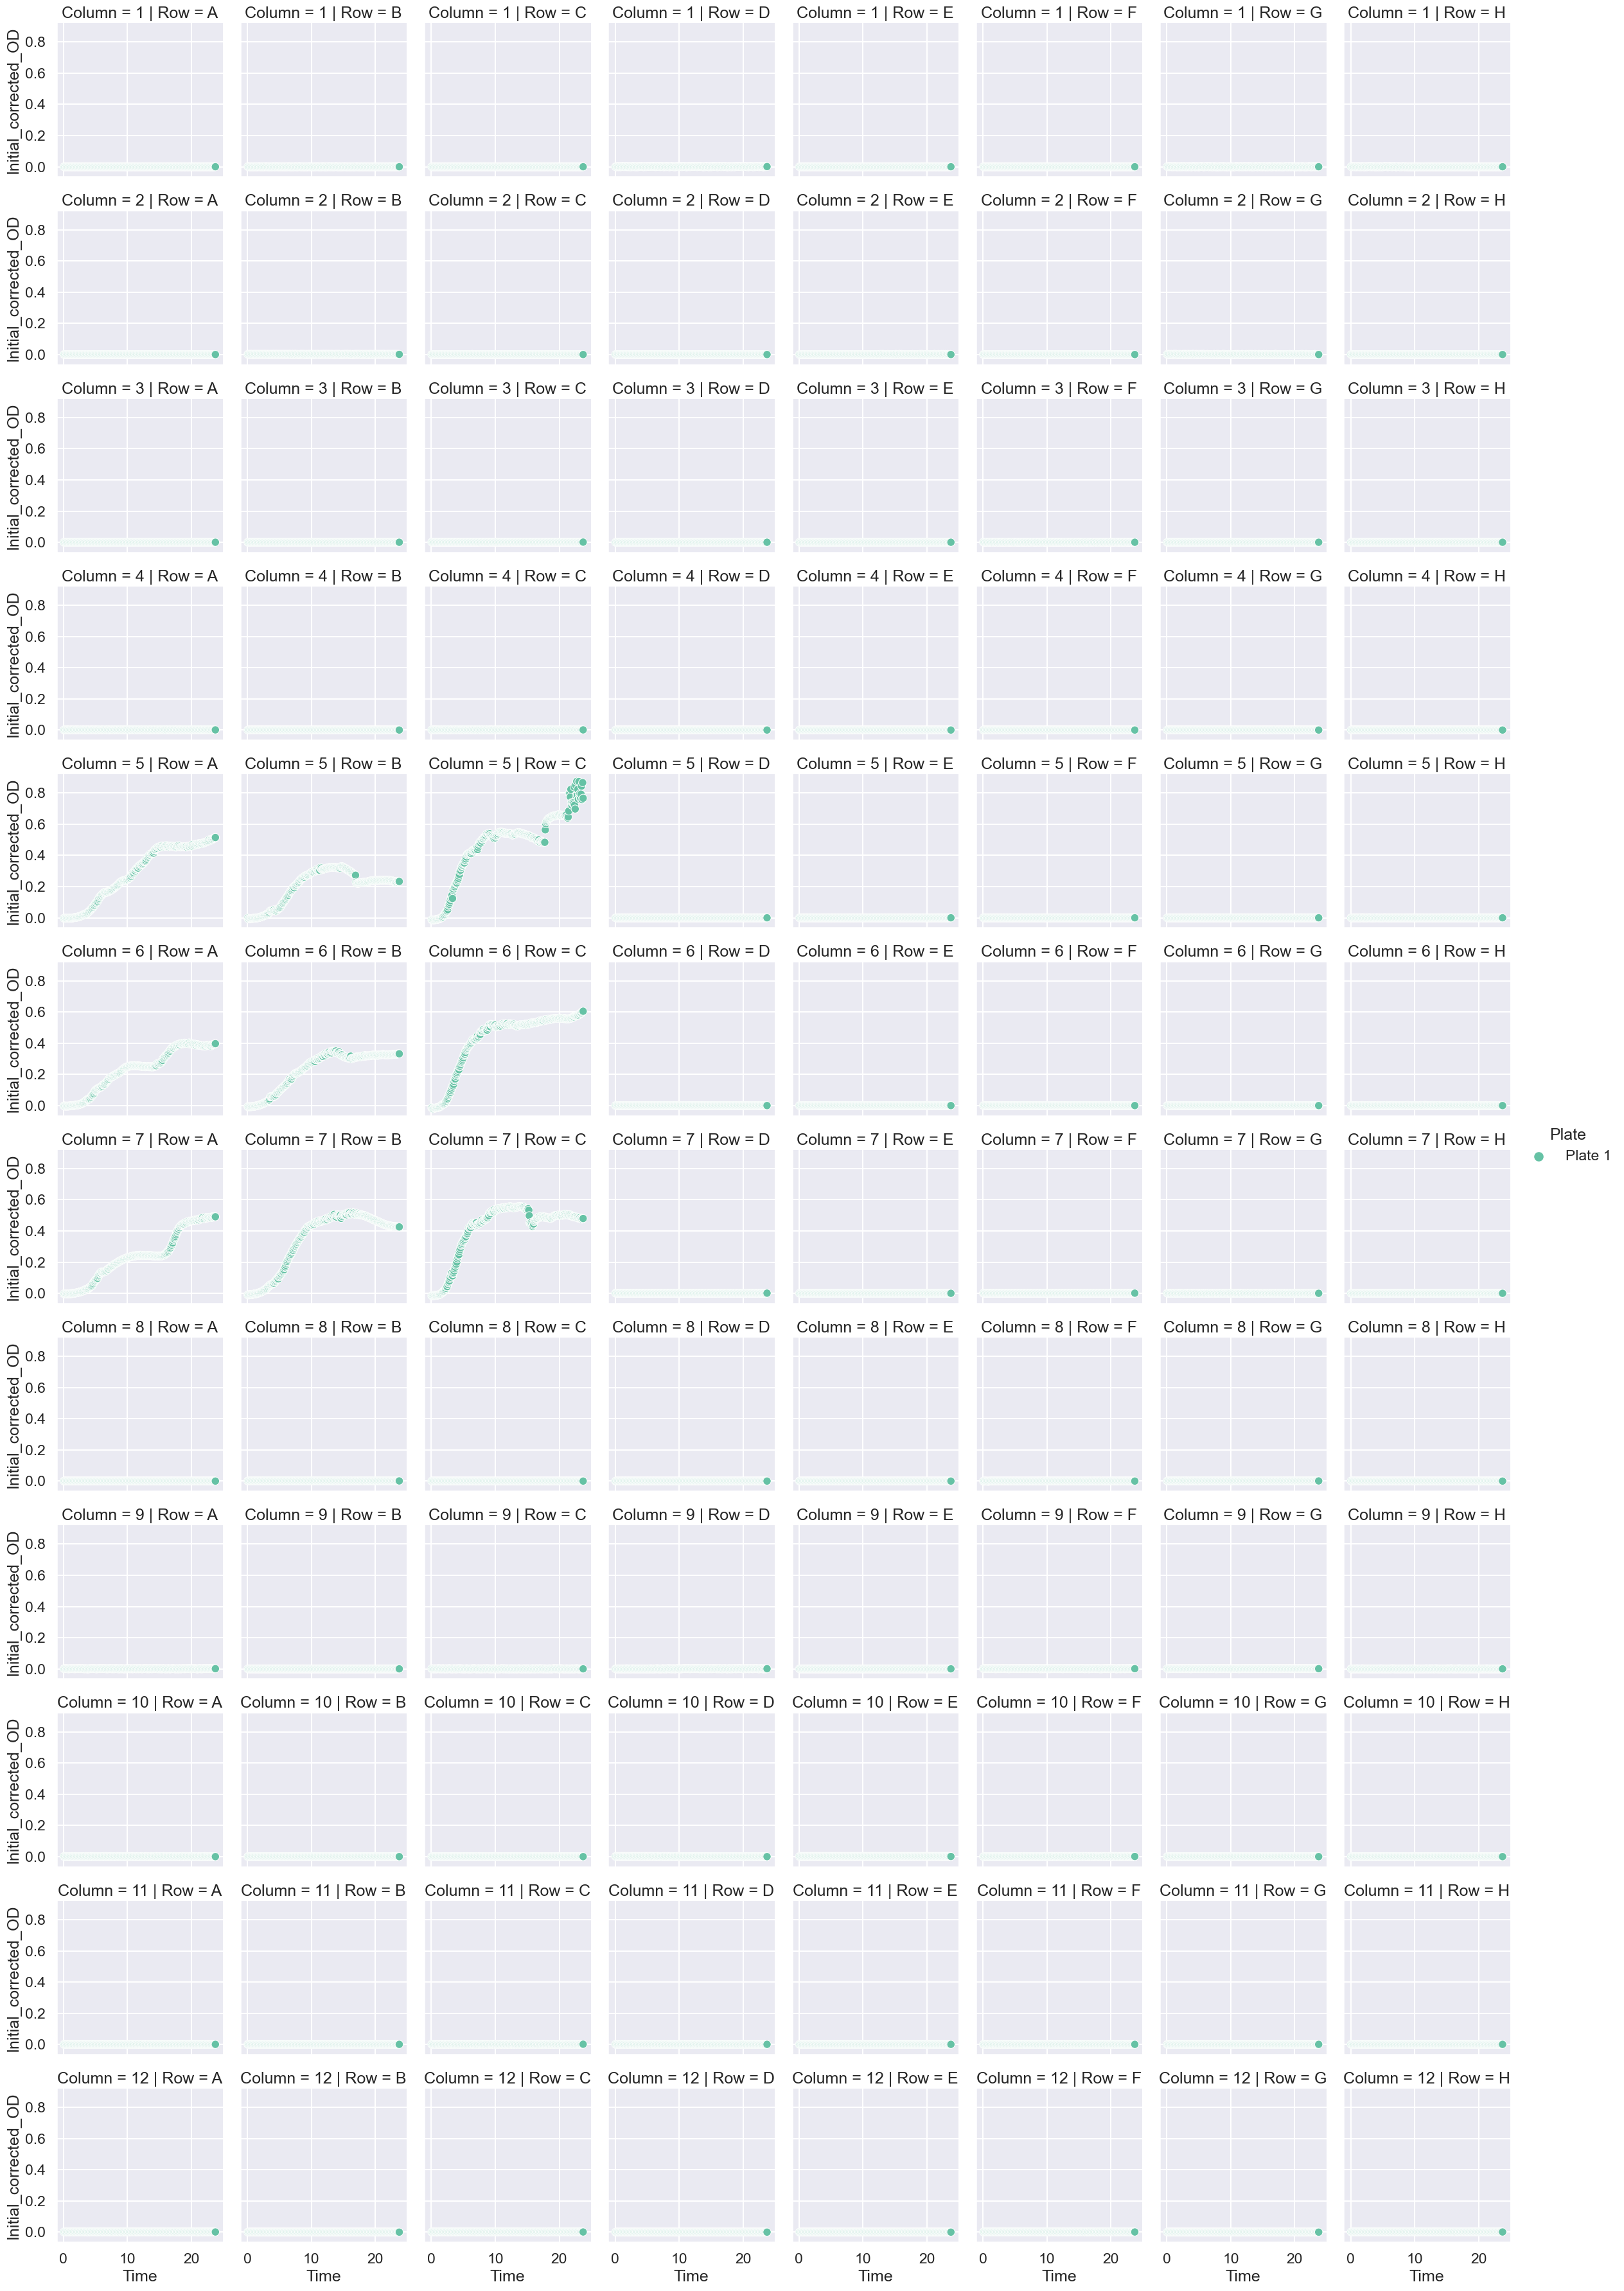

In [39]:
sns.set_context("talk")

sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", col="Row", row="Column", \
            # row="Genotype", 
            height=3, \
            # col_wrap=4,
            data=mdf)

In [40]:
f_mdf = mdf.filter(pl.col("Time") > 1).filter(pl.col("Initial_corrected_OD") > 0)

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_corrected_OD")).log())
    .alias("Log_initial_corrected_OD")
])

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_median_corrected_OD")).log())
    .alias("Log_initial_median_corrected_OD")
])


f_mdf = f_mdf.filter(pl.col("Log_initial_corrected_OD").is_not_nan())

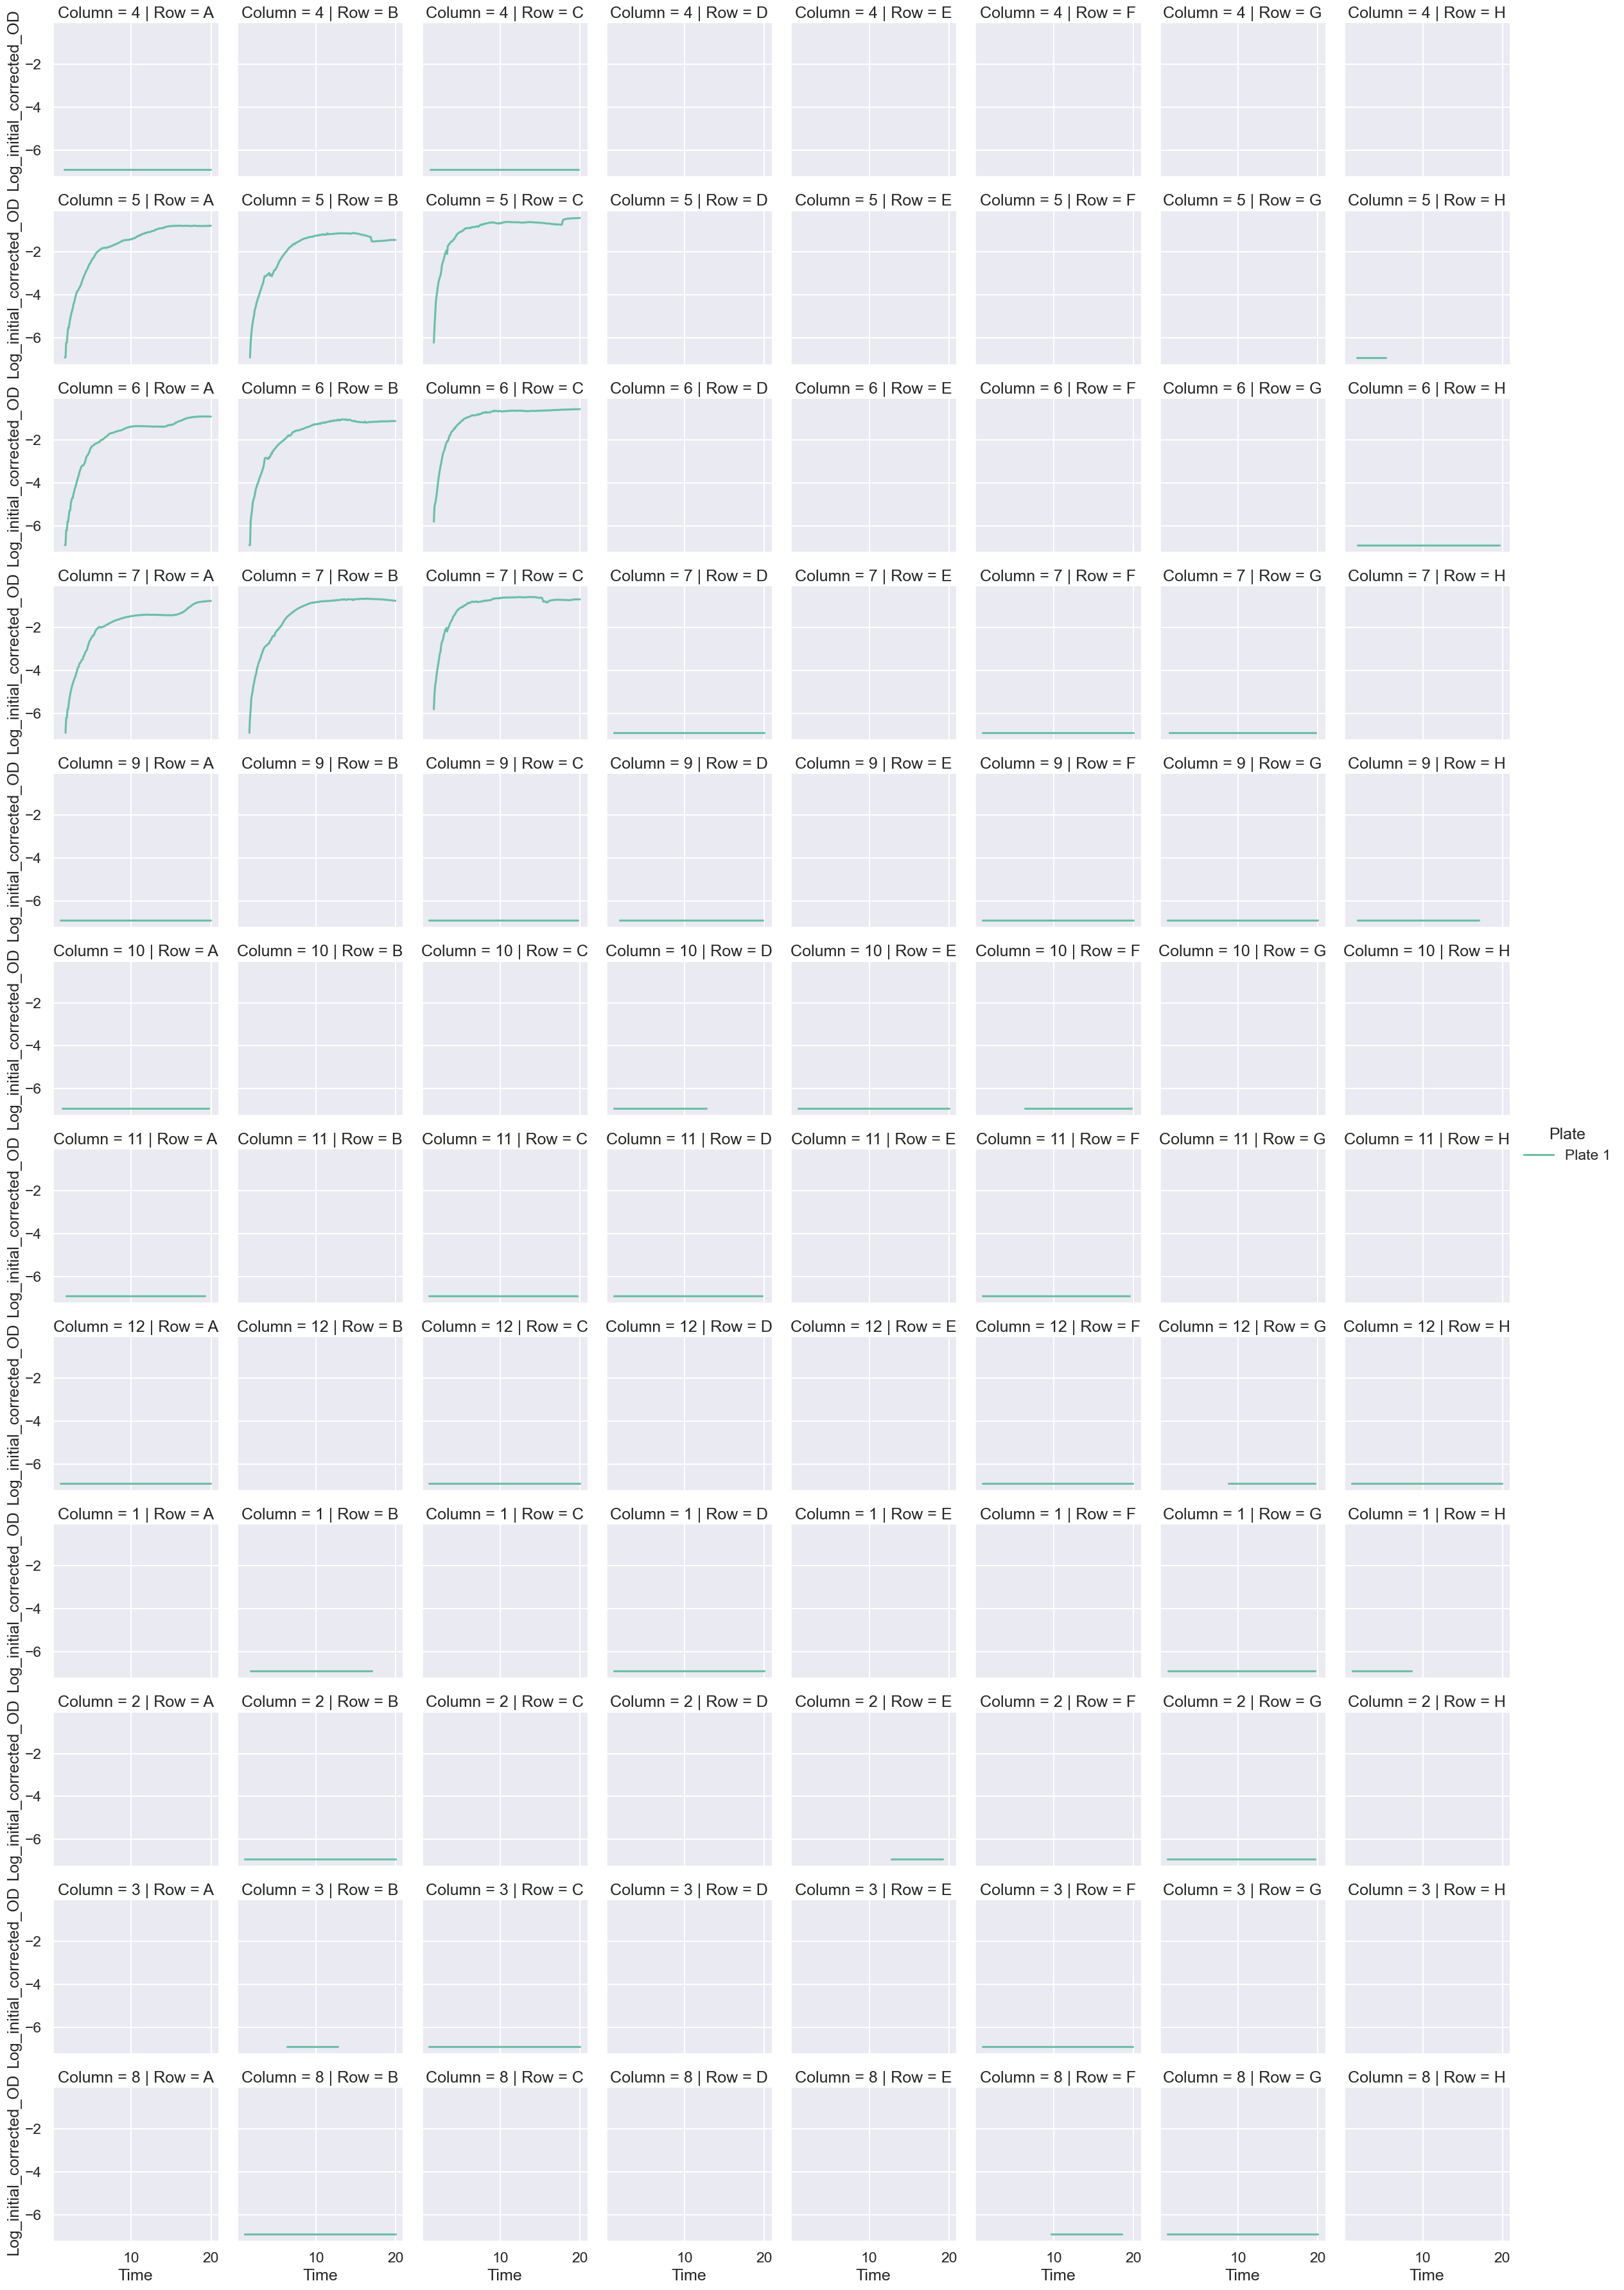

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Column", col="Row", height=3, \
                data=f_mdf.filter(pl.col("Time") < 20))


In [42]:
gr_df = f_mdf.filter( (pl.col("Time") < 20))
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= -4).group_by(["Plate", "Well"]).agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= -2).group_by(["Plate", "Well"]).agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on=["Plate", "Well"])
gr_df = gr_df.join(minimum_end_times, on=["Plate", "Well"])
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df.head(5)

# regress and pick top x 
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()

M = 0
N = 6
top_gr = pl.DataFrame(predicted_gr.sort_values(by=["Genotype", "Additive", "Plate", "slope"], ascending=False).groupby(['Genotype', 'Additive', 'Plate']).nth[M:N])
top_gr.head(7)

gr_df = gr_df.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"])

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_73157/739033653.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()


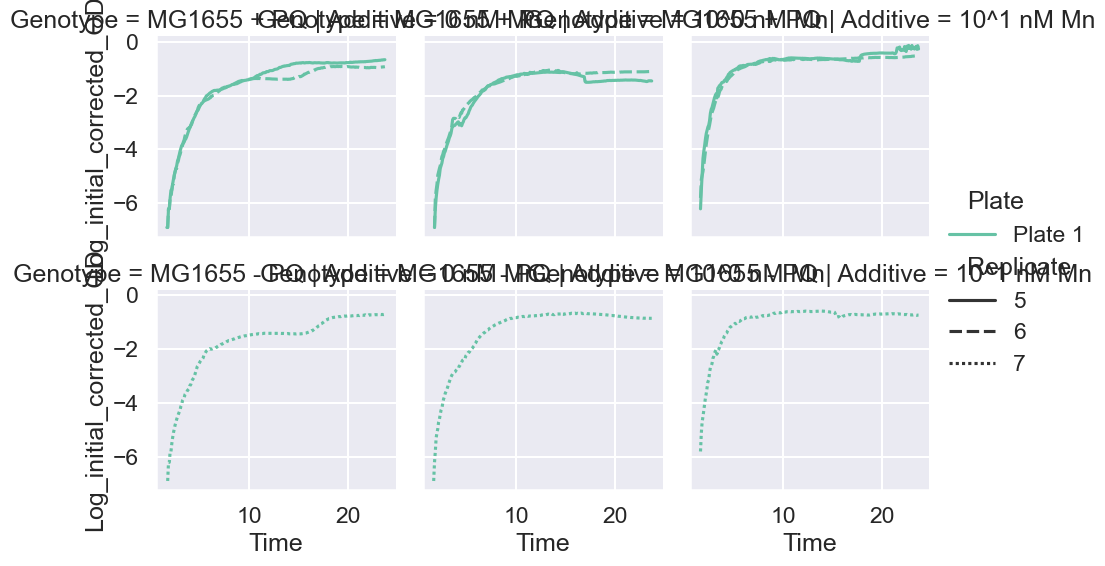

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Genotype", col="Additive", style="Replicate", height=3, \
                data=f_mdf.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"]))

# plt.savefig("weird_plate.png")

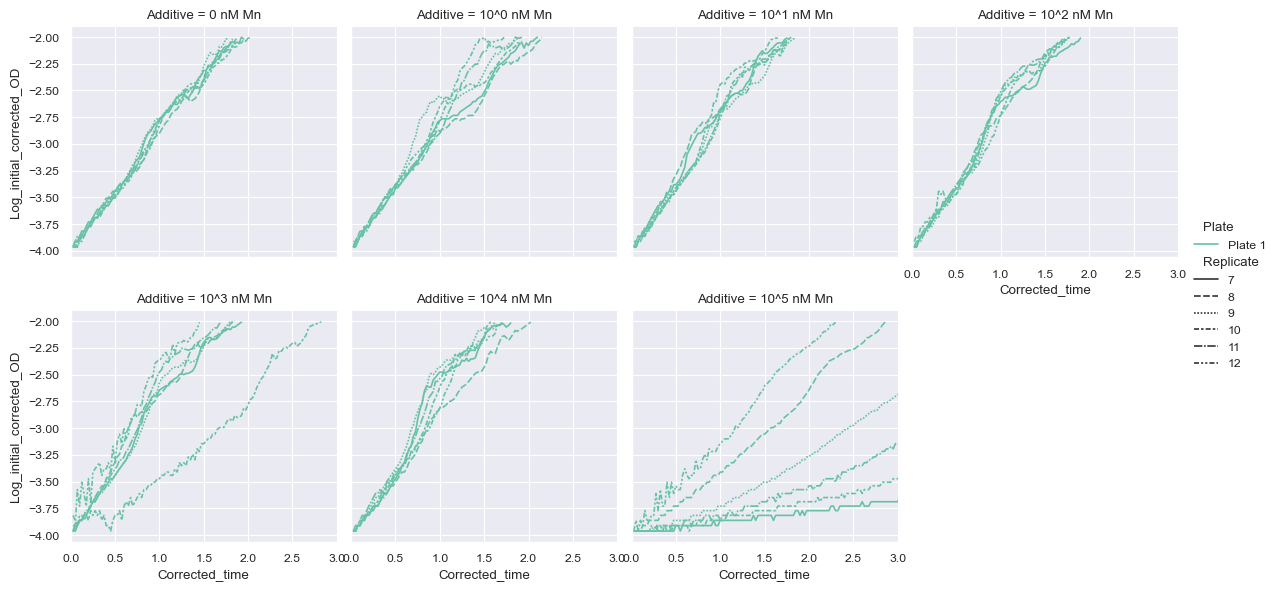

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.set_context("paper")
    sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Additive", style="Replicate", 
                col_wrap=4, 
                # row="Genotype",
                height=3, \
                data=gr_df)
    
    plt.xlim([0,3])

# plt.savefig("plates.png")

(0.0, 3.0)

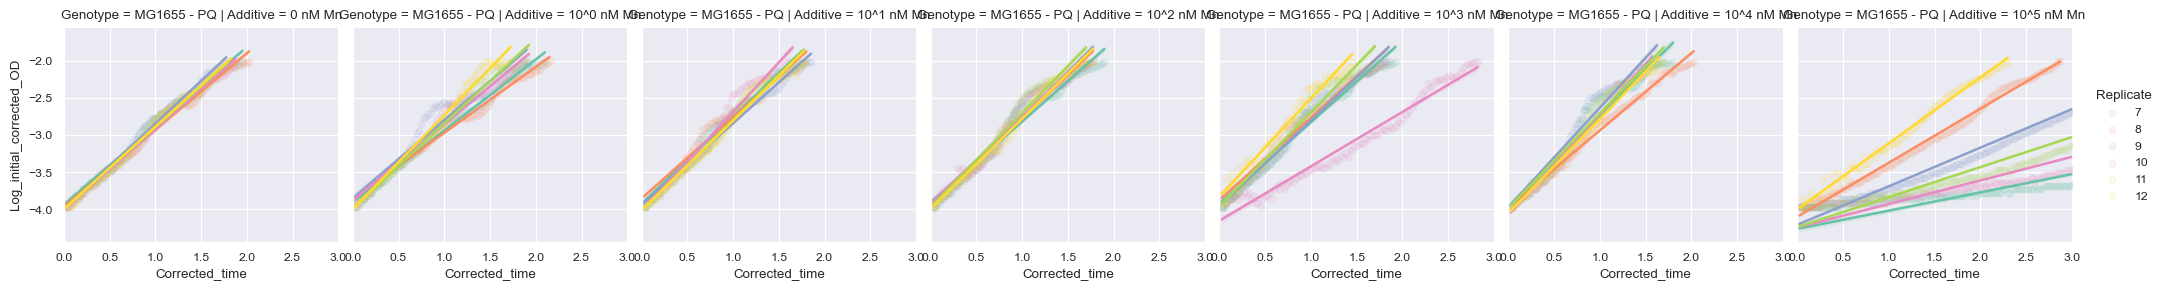

In [30]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Replicate", col="Additive", 
           # col_wrap=4,  \
           row="Genotype",
           height=3,
           data=gr_df.to_pandas(), scatter_kws = {"alpha": 0.1})

plt.xlim([0,3])


In [31]:
# sns.relplot(x="Time", y="Log_initial_corrected_OD", kind="line", row="Replicate", col="Additive", height=3, \
#             data=f_mdf.filter(pl.col("Time") < 15))

In [32]:
# sns.set_context("paper")

# sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", style="Replicate", kind="scatter", col="Additive", \
#             # row="Genotype", height=3, \
#             col_wrap=4,
#             data=mdf)

In [33]:
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std.columns = gr_mean_std.columns.get_level_values(1)
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std["mean"]
# gr_mean_std = gr_mean_std.reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"]
predicted_gr

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_73157/544480332.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])


,Genotype,Additive,Replicate,Plate,slope,intercept,slope_e,intercept_e,doubling_time
0,MG1655 - PQ,0 nM Mn,7,Plate 1,1.060914,-3.934522,0.012231,0.013903,0.653349
1,MG1655 - PQ,0 nM Mn,8,Plate 1,1.031036,-3.958725,0.009663,0.011402,0.672282
2,MG1655 - PQ,0 nM Mn,9,Plate 1,1.152213,-3.997043,0.013259,0.013731,0.601579
3,MG1655 - PQ,0 nM Mn,10,Plate 1,1.080386,-4.000244,0.012565,0.013738,0.641573
4,MG1655 - PQ,0 nM Mn,11,Plate 1,1.095992,-3.989696,0.011502,0.012077,0.632438
5,MG1655 - PQ,0 nM Mn,12,Plate 1,1.112285,-3.996978,0.011835,0.012598,0.623174
6,MG1655 - PQ,10^0 nM Mn,7,Plate 1,0.958942,-3.898150,0.011343,0.013875,0.722825
7,MG1655 - PQ,10^0 nM Mn,8,Plate 1,0.887076,-3.855383,0.009720,0.012170,0.781384
8,MG1655 - PQ,10^0 nM Mn,9,Plate 1,1.052131,-3.849063,0.027763,0.030756,0.658803
9,MG1655 - PQ,10^0 nM Mn,10,Plate 1,1.024640,-3.879569,0.019547,0.021936,0.676479


In [34]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    filter_df = pl.DataFrame(predicted_gr).filter((pl.col("Genotype") == "MG1655"))
    filter_df.head(5)
    
    g = sns.catplot(x="Genotype", y="slope", hue="Additive", 
                    data=filter_df.to_pandas(), kind="bar",  
                    height=5, aspect=1, alpha=0.5, errorbar="ci",
                    col="Plate", col_wrap=3
                       );
    g.map_dataframe(sns.stripplot, x="Genotype", y="slope", 
                    hue="Additive", palette="Set2",
                    alpha=0.6, dodge=True)
    
    plt.title("Maximum growth rate, average (bar) and individual measurements (point), n=3. 95% CI shown.")
    plt.ylim([0.8, 1.4])
    
    plt.show()
    
   #  g.savefig("story1.png")

ValueError: min() arg is an empty sequence